<a href="https://colab.research.google.com/github/kartikgill/The-GAN-Book/blob/main/Skill-08/maps-Pix2Pix/pix2pix-GAN-maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Useful Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [ ]:
import tensorflow
print (tensorflow.__version__)

2.4.0


# Download and extract Data

In [ ]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

--2020-12-29 11:29:26--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  3.59MB/s    in 63s     

2020-12-29 11:30:30 (3.79 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



In [ ]:
!tar -zxf maps.tar.gz

In [ ]:
!ls

maps  maps.tar.gz  sample_data


In [ ]:
import glob
train_files = glob.glob('maps/train/*.jpg')
test_files = glob.glob('maps/val/*.jpg')

In [ ]:
len(train_files), len(test_files)

(1096, 1098)

In [ ]:
import cv2
for file in train_files[:10]:
    map = cv2.imread(file)
    print (map.shape)

(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)


# Display few Samples

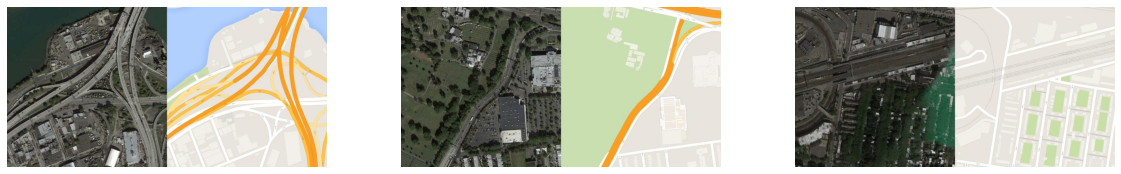

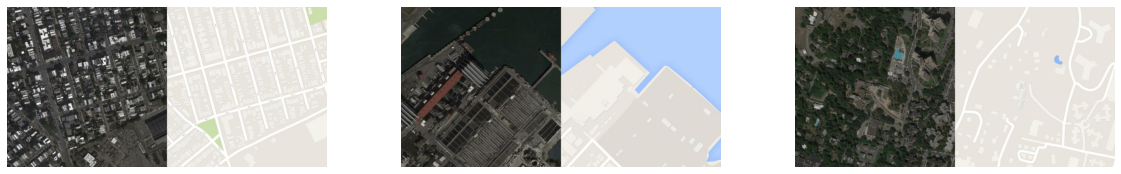

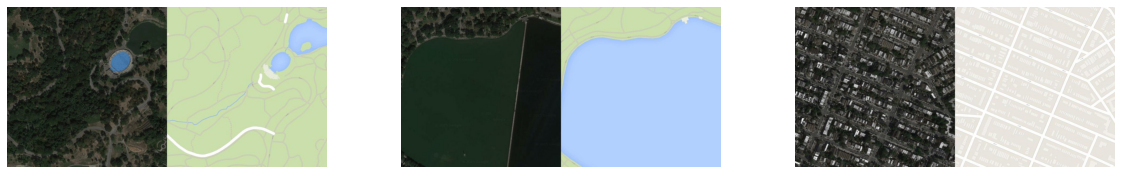

In [ ]:
for k in range(3):
    plt.figure(figsize=(20, 10))
    for j in range(3):
        file = np.random.choice(train_files)
        map = cv2.imread(file)
        map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
        plt.subplot(330 + 1 + j)
        plt.imshow(map)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Input vs Output images separately

Input Images


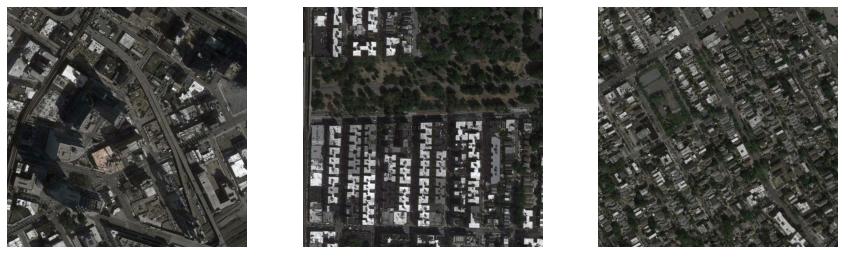

Output Images


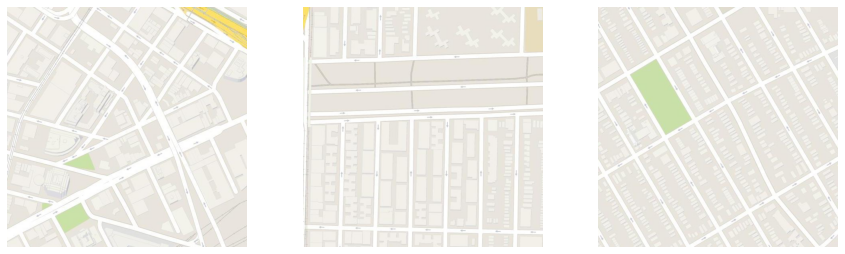

In [ ]:
maps = []
for j in range(3):
    file = np.random.choice(train_files)
    map = cv2.imread(file)
    map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
    maps.append(map)

print ('Input Images')
plt.figure(figsize=(15, 15))
for j, map in enumerate(maps):
    map1 = map[:, :map.shape[1]//2]
    plt.subplot(330 + 1 + j)
    plt.imshow(map1)
    plt.axis('off')
    #plt.title(trainY[i])
plt.show()

print ('Output Images')
plt.figure(figsize=(15, 15))
for j, map in enumerate(maps):
    map2 = map[:, map.shape[1]//2:]
    plt.subplot(330 + 1 + j)
    plt.imshow(map2)
    plt.axis('off')
    #plt.title(trainY[i])
plt.show()

# Define Generator Model (U-Net Like)

In [ ]:
import tensorflow_addons as tfa

In [ ]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tfa.layers.InstanceNormalization()(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [ ]:
source_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

e1 = encoder_layer(source_image_input, 64, bn=False)#64
e2 = encoder_layer(e1, 128)#128
e3 = encoder_layer(e2, 256)#256
e4 = encoder_layer(e3, 512)#512
e5 = encoder_layer(e4, 512)#512
e6 = encoder_layer(e5, 512)#512
e7 = encoder_layer(e6, 512)#512

bottle_neck = tensorflow.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same')(e7)
b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

d1 = decoder_layer(b, e7, 512)#512
d2 = decoder_layer(d1, e6, 512)#512
d3 = decoder_layer(d2, e5, 512)#512
d4 = decoder_layer(d3, e4, 512)#512
d5 = decoder_layer(d4, e3, 256)#256
d6 = decoder_layer(d5, e2, 128)#128
d7 = decoder_layer(d6, e1, 64)#64

decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)

generator_network = tensorflow.keras.models.Model(inputs=source_image_input, outputs=translated_image)
print (generator_network.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu[0][0]                
______________________________________________________________________________________________

# Define Discriminator Network

In [ ]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tfa.layers.InstanceNormalization()(x)
    return x

In [ ]:
source_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))
target_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

combined = tensorflow.keras.layers.Concatenate(axis=-1)([source_image_input, target_image_input])

x = my_conv_layer(combined, 64, bn=False)#64
x = my_conv_layer(x, 128)#128
x = my_conv_layer(x, 256)#256
x = my_conv_layer(x, 512)#512

patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=[source_image_input, target_image_input], outputs=patch_features)
print (discriminator_network.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 64) 6208        concatenate_7[0][0]        

In [ ]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# Define Pix2Pix GAN

In [ ]:
discriminator_network.trainable=False

g_output = generator_network(source_image_input)
d_output = discriminator_network([source_image_input, g_output])

pix2pix = tensorflow.keras.models.Model(inputs=source_image_input, outputs=[d_output, g_output])
pix2pix.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 256, 256, 3)  54419459    input_2[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 16, 16, 1)    2769601     input_2[0][0]                    
                                                                 model[0][0]                      
Total params: 57,189,060
Trainable params: 54,419,459
Non-trainable params: 2,769,601
__________________________________________________________________________________________________


# Compiling Pix2Pix

In [ ]:
pix2pix.compile(loss=['mse', 'mae'], optimizer=adam_optimizer, loss_weights=[1, 100])

# Define Data Generators

In [ ]:
def get_predictions(input_sample, generator_network):
    input_sample = np.expand_dims(input_sample, axis=0)
    output_sample = generator_network.predict_on_batch(input_sample)
    return output_sample

def get_generated_samples(generator_network, maps_input):
    generated_samples = generator_network.predict_on_batch(maps_input)
    return generated_samples

def get_map_samples(batch_size):
    random_files = np.random.choice(train_files, size=batch_size)
    maps_input = []
    maps_output = []
    for file in random_files:
        map = cv2.imread(file)
        map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
        map1 = map[:, :map.shape[1]//2]
        map2 = map[:, map.shape[1]//2:]
        map1 = cv2.resize(map1, (256, 256))
        map2 = cv2.resize(map2, (256, 256))
        maps_input.append((map1-127.5)/127.5)
        maps_output.append((map2-127.5)/127.5)
    maps_input = np.array(maps_input)
    maps_output = np.array(maps_output)
    return maps_input, maps_output

def show_generator_results(generator_network):
    maps = []
    for j in range(3):
        file = np.random.choice(test_files)
        map = cv2.imread(file)
        map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
        maps.append(map)

    print ('Input Images')
    plt.figure(figsize=(13, 13))
    for j, map in enumerate(maps):
        map1 = map[:, :map.shape[1]//2]
        map1 = cv2.resize(map1, (256, 256))
        plt.subplot(330 + 1 + j)
        plt.imshow(map1)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Predicted Output Images')
    plt.figure(figsize=(13, 13))
    for j, map in enumerate(maps):
        map1 = map[:, :map.shape[1]//2]
        map1 = cv2.resize(map1, (256, 256))
        map1 = (map1-127.5)/127.5
        output = get_predictions(map1, generator_network)[0]
        output = (output+1.0)/2.0
        plt.subplot(330 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Real Output Images')
    plt.figure(figsize=(13, 13))
    for j, map in enumerate(maps):
        map2 = map[:, map.shape[1]//2:]
        map2 = cv2.resize(map2, (256, 256))
        plt.subplot(330 + 1 + j)
        plt.imshow(map2)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Training GAN

In [ ]:
len(train_files)

1096

In [ ]:
epochs = 500
batch_size = 1
steps = 1096

for i in range(0, epochs):
    if (i%5 == 0):
        show_generator_results(generator_network)
    for j in range(steps):
        maps_input, maps_output = get_map_samples(batch_size=batch_size)
        generated_maps_output = get_generated_samples(generator_network, maps_input)

        fake_patch = np.zeros((batch_size, 16, 16, 1))
        real_patch = np.ones((batch_size, 16, 16, 1))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d1 = discriminator_network.train_on_batch([maps_input, maps_output], real_patch)
        loss_d2 = discriminator_network.train_on_batch([maps_input, generated_maps_output], fake_patch)
        
        loss_d = (np.add(loss_d1, loss_d2))/2.0
        
        
        maps_input, maps_output = get_map_samples(batch_size=batch_size)
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        real_patch = np.ones((batch_size, 16, 16, 1))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g, _, _ = pix2pix.train_on_batch(maps_input, [real_patch, maps_output])
        
        if j%100 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))   

# Results

Input Images


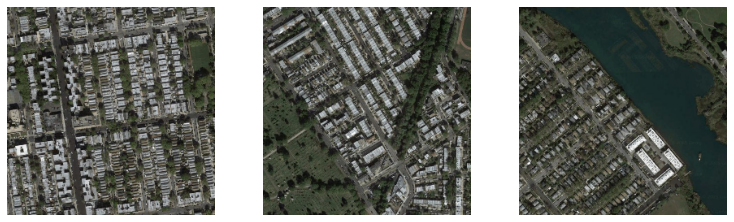

Predicted Output Images


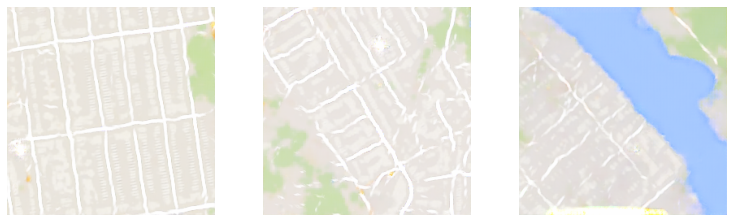

Real Output Images


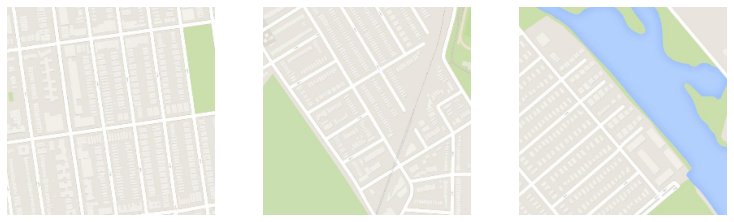

Input Images


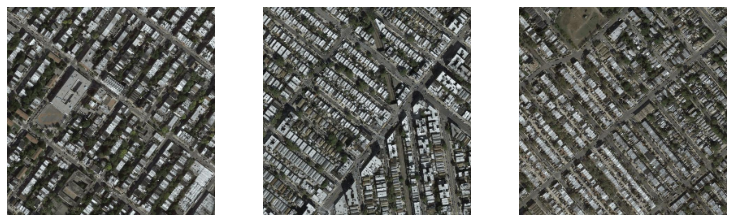

Predicted Output Images


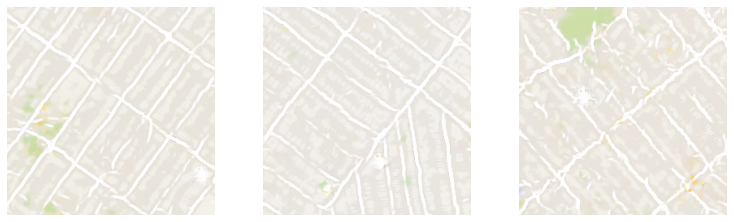

Real Output Images


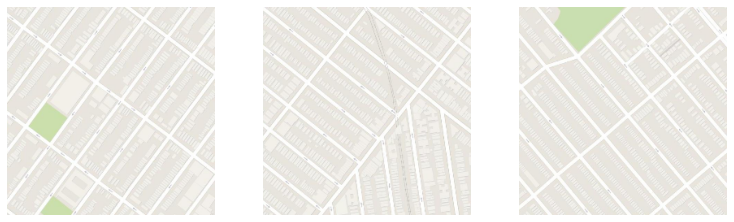

Input Images


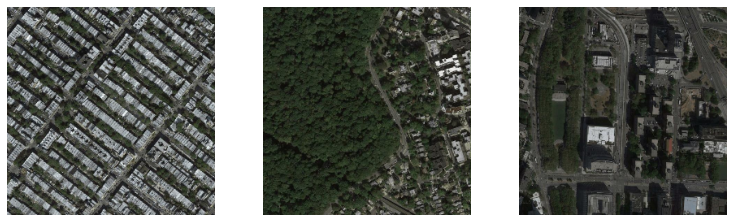

Predicted Output Images


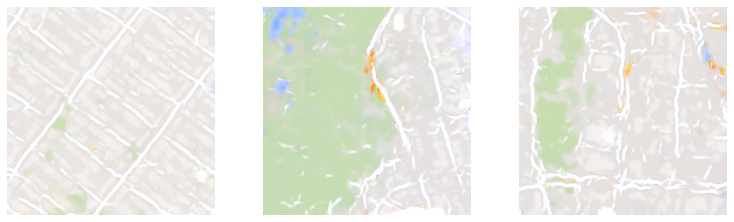

Real Output Images


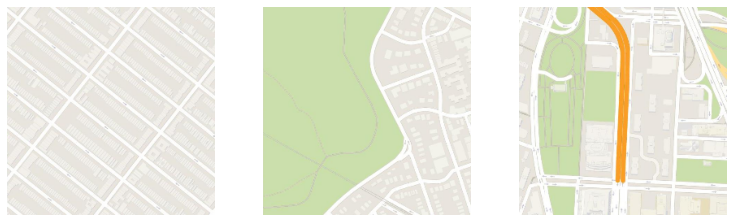

Input Images


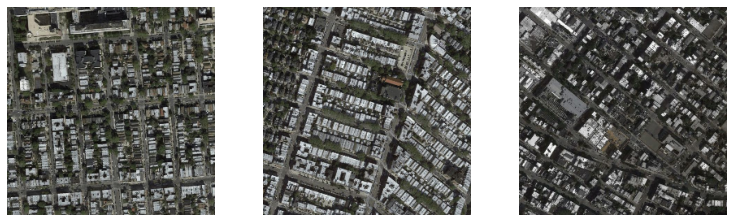

Predicted Output Images


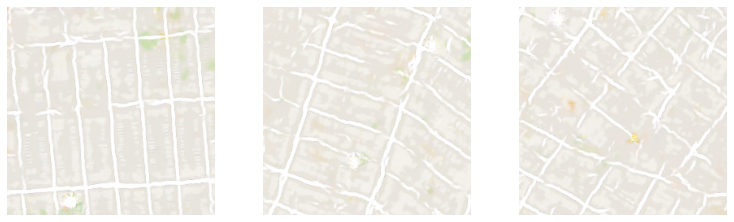

Real Output Images


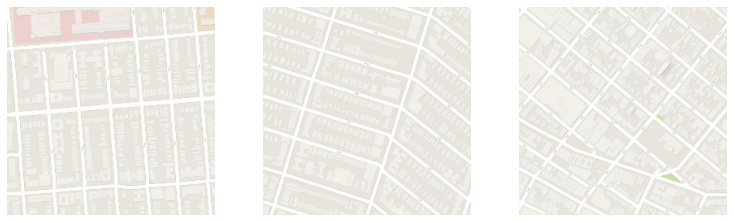

Input Images


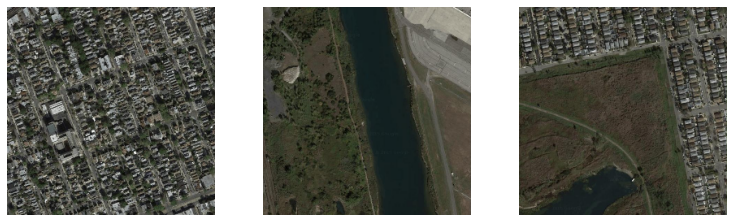

Predicted Output Images


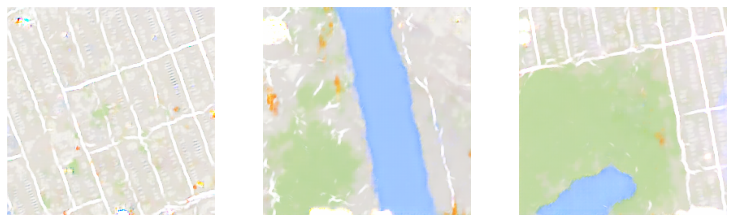

Real Output Images


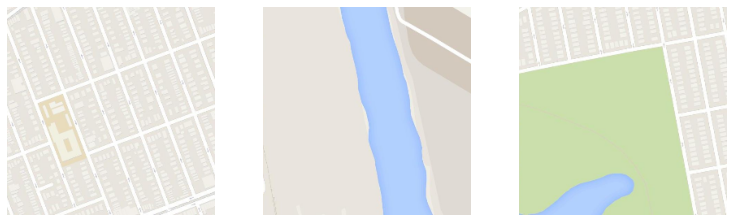

In [ ]:
for i in range(5):
    show_generator_results(generator_network)